Prerequisites – Download nltk stopwords and spacy model

In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weiweizheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Import Packages

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

prepare stopwords

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['alexa', 'siri', 'heygoogle', 'cortana','would','could'])
# stop_words.extend(['alexa', 'siri', 'heygoogle', 'cortana', 'apple', 'google', 'amazon', 'microsoft'])

In [4]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

convert data to list

In [7]:
df = pd.read_csv('../data/text_071031_180729.csv', names = ['text'])
df = df.drop_duplicates()
data = df['text'].tolist()

In [8]:
df.head()

,text
0,"interesting times, interesting questions ! Ale..."
4,IOT NEWS: Not everyone likes digital voice ass...
5,Did you know that you can control your @dishne...
8,.@808_Audio wireless #speaker features #Alexa ...
9,@BigstickCarpet Awesome! I'm doing a workshop ...


In [9]:
df.shape

(128788, 1)

Tokenize words and Clean-up text

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['interesting', 'times', 'interesting', 'questions', 'alexa', 'are', 'you', 'safe', 'for', 'my', 'kids', 'ai', 'alexa']]


Creating Bigram and Trigram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=200, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/weiweizheng/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['interesting', 'times', 'interesting', 'questions', 'alexa', 'are', 'you', 'safe', 'for', 'my', 'kids', 'ai', 'alexa']


Remove Stopwords, Make Bigrams and Lemmatize

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['interesting', 'time', 'interesting', 'question', 'safe', 'kid', 'ai']]


Create the Dictionary and Corpus needed for Topic Modeling

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [16]:
id2word[0]

'ai'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('ai', 1),
  ('interesting', 2),
  ('kid', 1),
  ('question', 1),
  ('safe', 1),
  ('time', 1)]]

Building the Topic Model

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

 View the topics in LDA model

In [19]:
# Print the Keyword in the 30 topics
pprint(lda_model.print_topics(num_words = 20))
doc_lda = lda_model[corpus]

[(17,
  '0.068*"amazonalexa" + 0.065*"try" + 0.054*"change" + 0.046*"much" + '
  '0.033*"house" + 0.028*"site" + 0.025*"word" + 0.023*"worldcup" + '
  '0.019*"beta" + 0.017*"full" + 0.016*"trump" + 0.015*"instead" + '
  '0.015*"excited" + 0.014*"project" + 0.013*"research" + 0.013*"tunein" + '
  '0.009*"upgrade" + 0.009*"amazonhelp" + 0.009*"account" + 0.008*"scientist"'),
 (23,
  '0.089*"today" + 0.031*"well" + 0.030*"open" + 0.030*"morning" + '
  '0.028*"test" + 0.025*"ever" + 0.021*"man" + 0.021*"shopping" + '
  '0.020*"alexadevs" + 0.020*"developer" + 0.019*"announce" + 0.019*"wifi" + '
  '0.018*"describe" + 0.018*"activity" + 0.018*"plug" + 0.017*"fact" + '
  '0.013*"maybe" + 0.013*"together" + 0.012*"remind" + 0.012*"food"'),
 (7,
  '0.326*"amazonecho" + 0.052*"dot" + 0.044*"give" + 0.039*"really" + '
  '0.031*"audio" + 0.031*"privacy" + 0.023*"machinelearn" + 0.022*"marketing" '
  '+ 0.015*"golf" + 0.011*"tweet" + 0.011*"homeautomation" + 0.011*"half" + '
  '0.010*"gesture" + 0.

Compute Model Perplexity and Coherence Score

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.383007718114296

Coherence Score:  0.3642632229515034


Visualize the topics-keywords

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     5.642010        1       1 -0.077504  0.400034
4      4.410773        1       2 -0.027683  0.035152
16     4.259652        1       3 -0.041024  0.112665
11     4.100011        1       4 -0.007037  0.001221
19     4.010332        1       5  0.010522 -0.003779
21     3.917051        1       6 -0.053623 -0.023591
0      3.873207        1       7  0.004465 -0.013501
5      3.736726        1       8 -0.433991 -0.109329
26     3.602192        1       9  0.007364  0.003437
25     3.572598        1      10  0.021642 -0.021128
14     3.372121        1      11  0.028546 -0.020989
28     3.314168        1      12  0.042129 -0.032664
15     3.222255        1      13  0.011820 -0.006317
2      3.180223        1      14 -0.027089 -0.039050
29     3.165924        1      15  0.043734  0.008904
8      3.089534        1      16  0.028450 -0.027034
20     3.068425        1      17  0.031426 -0.004586
6      3.030159        1      18  0.007119  0.061684
22     2.998519        1      19  0.045976 -0.026250
1      2.995929        1      20  0.054180 -0.015614
24     2.929851        1      21  0.030312 -0.025614
3      2.889521        1      22 -0.023090 -0.040823
12     2.876001        1      23  0.013051 -0.034393
18     2.819101        1      24  0.022879 -0.020529
13     2.760719        1      25  0.050061 -0.028265
9      2.736827        1      26  0.041091 -0.028362
27     2.716145        1      27  0.041626 -0.028290
7      2.696977        1      28  0.037852 -0.014717
23     2.640462        1      29  0.059525 -0.017206
17     2.372582        1      30  0.057272 -0.041065, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
38     Default  24090.000000        amazon  24090.000000  30.0000  30.0000
85     Default   9732.000000    amazonecho   9732.000000  29.0000  29.0000
52     Default  10579.000000         apple  10579.000000  28.0000  28.0000
14     Default  10419.000000         voice  10419.000000  27.0000  27.0000
61     Default   8632.000000           get   8632.000000  26.0000  26.0000
168    Default   8467.000000           ask   8467.000000  25.0000  25.0000
0      Default   7880.000000            ai   7880.000000  24.0000  24.0000
107    Default   7722.000000          echo   7722.000000  23.0000  23.0000
98     Default   6230.000000          play   6230.000000  22.0000  22.0000
999    Default   6275.000000          rank   6275.000000  21.0000  21.0000
21     Default   6157.000000           use   6157.000000  20.0000  20.0000
237    Default   5597.000000        google   5597.000000  19.0000  19.0000
82     Default   6093.000000           new   6093.000000  18.0000  18.0000
35     Default   5736.000000         skill   5736.000000  17.0000  17.0000
88     Default   5085.000000          make   5085.000000  16.0000  16.0000
43847  Default   5088.000000       rankbio   5088.000000  15.0000  15.0000
6      Default   5165.000000     assistant   5165.000000  14.0000  14.0000
63     Default   5036.000000           say   5036.000000  13.0000  13.0000
417    Default   4294.000000        device   4294.000000  12.0000  12.0000
57     Default   4939.000000    technology   4939.000000  11.0000  11.0000
99     Default   4623.000000         smart   4623.000000  10.0000  10.0000
20     Default   4320.000000          know   4320.000000   9.0000   9.0000
81     Default   4409.000000          home   4409.000000   8.0000   8.0000
582    Default   4250.000000        iphone   4250.000000   7.0000   7.0000
103    Default   4365.000000          work   4365.000000   6.0000   6.0000
677    Default   3886.000000        friend   3886.000000   5.0000   5.0000
873    Default   3431.000000          show   3431.000000   4.0000   4.0000
15     Default   3284.000000           app   3284.000000   3.0000   3.0000
405    Defa

Building LDA Mallet Model

In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '../mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=34, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False, num_words=20))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('listen', 0.0970793776371308),
   ('open', 0.030689609704641352),
   ('ifttt', 0.023602320675105485),
   ('security', 0.021492616033755275),
   ('album', 0.020800369198312237),
   ('run', 0.014965717299578058),
   ('job', 0.014570147679324895),
   ('door', 0.014240506329113924),
   ('version', 0.013416402953586497),
   ('hire', 0.013317510548523207),
   ('camera', 0.012757120253164557),
   ('close', 0.010845200421940928),
   ('nowplay', 0.01015295358649789),
   ('front', 0.010119989451476793),
   ('kodi_tunein', 0.009131065400843881),
   ('software', 0.0089332805907173),
   ('point', 0.008537710970464135),
   ('blue', 0.007680643459915612),
   ('nowplaying', 0.007482858649789029),
   ('network', 0.007351002109704642)]),
 (17,
  [('smart', 0.12997407282155338),
   ('home', 0.12492954571074287),
   ('smarthome', 0.082065156126705),
   ('speaker', 0.07397700371998647),
   ('light', 0.04060985232780972),
   ('control', 0.026434449329275165),
   ('turn', 0.026406267613572315),
   (

How to find the optimal number of topics for LDA?

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=40, step=1)

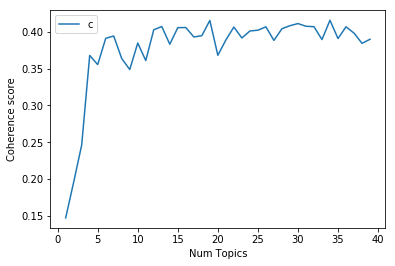

In [25]:
# Show graph
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.1472
Num Topics = 2  has Coherence Value of 0.1958
Num Topics = 3  has Coherence Value of 0.2461
Num Topics = 4  has Coherence Value of 0.3678
Num Topics = 5  has Coherence Value of 0.3554
Num Topics = 6  has Coherence Value of 0.391
Num Topics = 7  has Coherence Value of 0.3941
Num Topics = 8  has Coherence Value of 0.3635
Num Topics = 9  has Coherence Value of 0.3486
Num Topics = 10  has Coherence Value of 0.3846
Num Topics = 11  has Coherence Value of 0.3609
Num Topics = 12  has Coherence Value of 0.4027
Num Topics = 13  has Coherence Value of 0.407
Num Topics = 14  has Coherence Value of 0.383
Num Topics = 15  has Coherence Value of 0.4055
Num Topics = 16  has Coherence Value of 0.4057
Num Topics = 17  has Coherence Value of 0.3929
Num Topics = 18  has Coherence Value of 0.3946
Num Topics = 19  has Coherence Value of 0.4153
Num Topics = 20  has Coherence Value of 0.368
Num Topics = 21  has Coherence Value of 0.3887
Num Topics = 22  has Coher